<a href="https://colab.research.google.com/github/comparativechrono/miRNA/blob/main/working_scripts/miRNA_DESEQ2_UPDATED_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
BiocManager::install("DESeq2")


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'BiocVersion', 'DESeq2'

also installing the dependencies ‘formatR’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘GenomeInfoDb’, ‘XVector’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘matrixStats’, ‘locfit’, ‘MatrixGenerics’, ‘RcppArmadillo’


Old packages: 'curl', 'evaluate', 'foreign', 'MASS', 'openssl', 'pillar',
  'processx', 'Rcpp', 'rpart', 'testthat', 'xfun'



In [3]:
packageVersion("DESeq2")


[1] ‘1.46.0’

In [4]:
install.packages("Rtsne")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
# Load required library
library(DESeq2)
library(ggplot2)
library(Rtsne)
library(tidyr)
library(dplyr)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [6]:
#DATA WRANGLING AND RESHAPING

# Define file paths for abundance tables
files <- list(
  MB01 = "MB01.tsv",
  MB02 = "MB02.tsv",
  MB03 = "MB03.tsv",
  MB04 = "MB04.tsv",
  MB05 = "MB05.tsv",
  VS01 = "VS01.tsv",
  VS02 = "VS02.tsv",
  VS03 = "VS03.tsv",
  VS04 = "VS04.tsv",
  VS05 = "VS05.tsv"
)

# Read Kallisto abundance files and extract estimated counts
count_data <- lapply(files, function(f) {
  df <- read.table(f, header = TRUE, sep = "\t")
  setNames(df$tpm, df$target_id) # Extract counts, with miRNA/transcript IDs as rownames
})

# Combine into a single counts matrix
counts_matrix <- do.call(cbind, count_data)

# Rename columns based on sample names
colnames(counts_matrix) <- names(files)

# Create sample information (metadata)
coldata <- data.frame(
  row.names = colnames(counts_matrix),
  condition = factor(c("MB", "MB", "MB", "MB", "MB", "VS", "VS", "VS", "VS", "VS"),
                     levels = c("MB", "VS"))
)


In [7]:
## DESEQ2

# Create DESeq2 dataset
dds <- DESeqDataSetFromMatrix(countData = round(counts_matrix),
                              colData = coldata,
                              design = ~ condition)

# Run DESeq2 normalization and differential expression analysis
dds_all <- DESeq(dds)

# Filter transcripts with low counts across all samples
dds <- dds_all[rowSums(counts(dds_all)) > 0, ]

# Summary of results
res <- results(dds)
summary(res)

# Use varianceStabilizingTransformation for normalization
vsd <- varianceStabilizingTransformation(dds, blind = FALSE)

# Add annotation to results (log2 fold change and significance)
res$significance <- ifelse(res$padj < 0.05, "Significant", "Not Significant")

# Save normalized counts to file
write.csv(counts(dds, normalized = TRUE), "normalized_counts.csv")

# Save all normalized counts to file
write.csv(counts(dds_all, normalized = TRUE), "normalized_all_counts.csv")

# Save all results to file
write.csv(as.data.frame(res), "differential_expression_results.csv")

# Export only significant results to a separate file
sig_res <- subset(res, padj < 0.05)
write.csv(as.data.frame(sig_res), "significant_results.csv")

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 1423 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 12, 0.84%
LFC < 0 (down)     : 74, 5.2%
outliers [1]       : 465, 33%
low counts [2]     : 322, 23%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [8]:
# Summary Statistics
cat("\nSummary Statistics:\n")
cat("Total genes analyzed: ", nrow(res), "\n")
cat("Significantly upregulated (log2FC > 0, padj < 0.05): ",
    sum(res$log2FoldChange > 0 & res$padj < 0.05, na.rm = TRUE), "\n")
cat("Significantly downregulated (log2FC < 0, padj < 0.05): ",
    sum(res$log2FoldChange < 0 & res$padj < 0.05, na.rm = TRUE), "\n")


Summary Statistics:
Total genes analyzed:  1423 
Significantly upregulated (log2FC > 0, padj < 0.05):  8 
Significantly downregulated (log2FC < 0, padj < 0.05):  16 


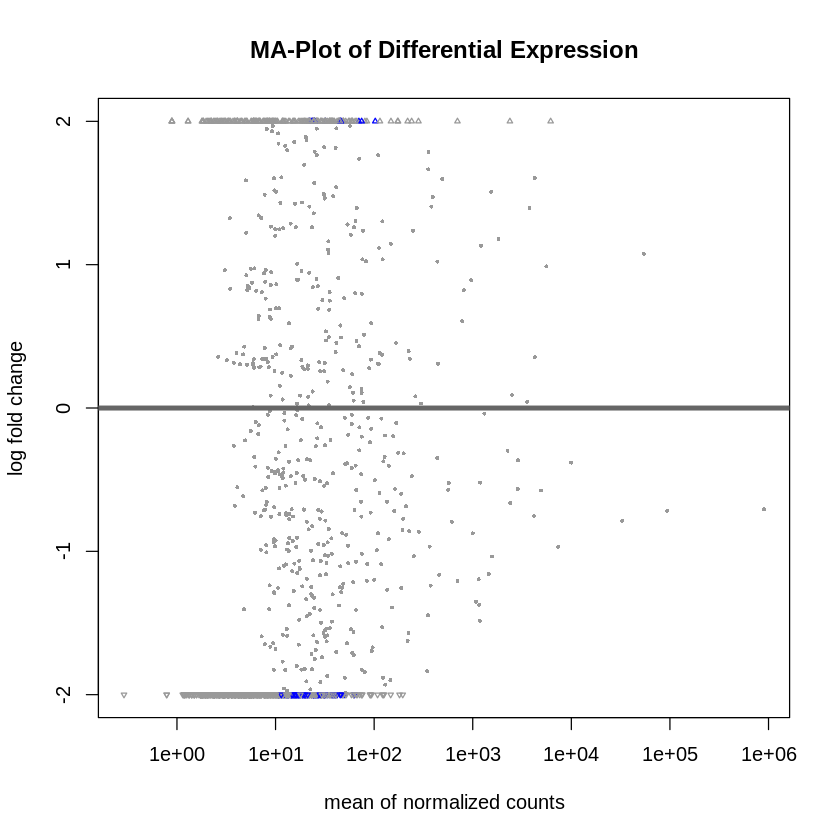

In [9]:
# MA-plot (DESeq2 default)
plotMA(res, ylim = c(-2, 2), main = "MA-Plot of Differential Expression")

Warning message:
“Removed 787 rows containing missing values or values outside the scale range
(`geom_point()`).”


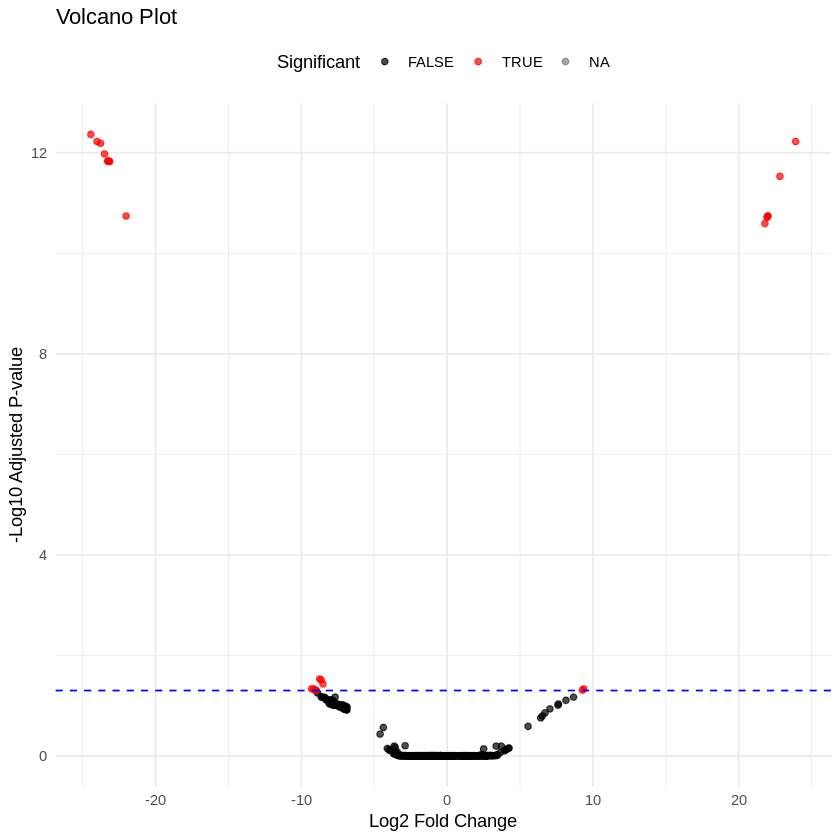

In [10]:
# Volcano plot
volcano_data <- as.data.frame(res)
volcano_data$Significant <- volcano_data$padj < 0.05
ggplot(volcano_data, aes(x = log2FoldChange, y = -log10(padj), color = Significant)) +
  geom_point(alpha = 0.7, size = 1.5) +
  scale_color_manual(values = c("black", "red")) +
  theme_minimal() +
  labs(title = "Volcano Plot",
       x = "Log2 Fold Change",
       y = "-Log10 Adjusted P-value") +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "blue") +
  theme(legend.position = "top")

using ntop=500 top features by variance



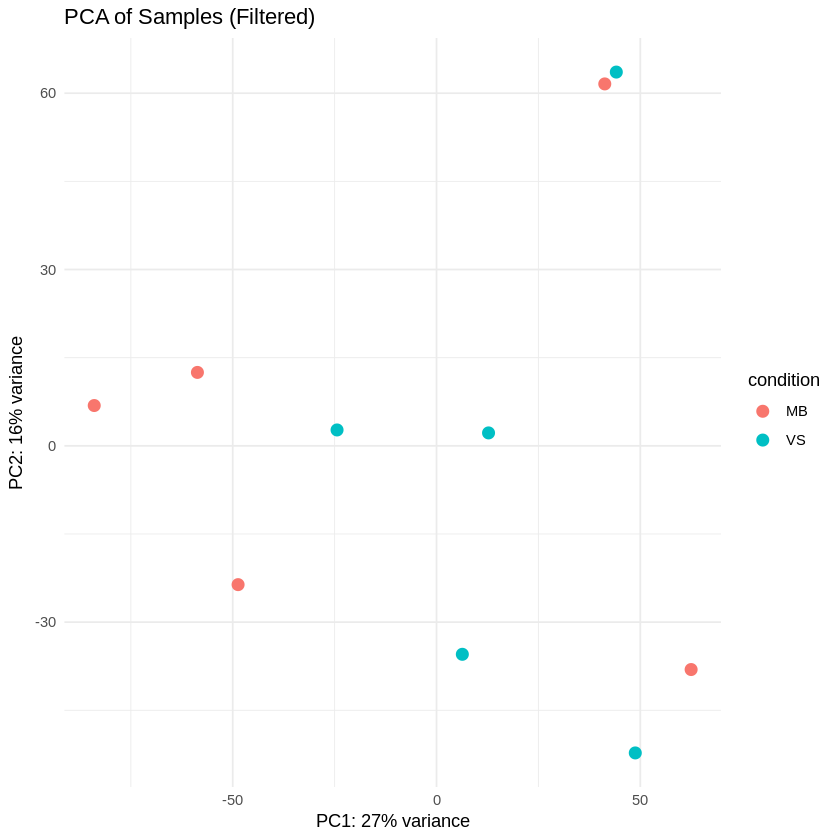

In [11]:
# PCA
pcaData <- plotPCA(vsd, intgroup = "condition", returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
ggplot(pcaData, aes(PC1, PC2, color = condition)) +
  geom_point(size = 3) +
  labs(title = "PCA of Samples (Filtered)",
       x = paste0("PC1: ", percentVar[1], "% variance"),
       y = paste0("PC2: ", percentVar[2], "% variance")) +
  theme_minimal()

Performing PCA
Read the 10 x 10 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 2, perplexity = 3.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.00 seconds (sparsity = 0.900000)!
Learning embedding...
Iteration 50: error is 51.539267 (50 iterations in 0.00 seconds)
Iteration 100: error is 71.932483 (50 iterations in 0.00 seconds)
Iteration 150: error is 62.847518 (50 iterations in 0.00 seconds)
Iteration 200: error is 58.007984 (50 iterations in 0.00 seconds)
Iteration 250: error is 44.688757 (50 iterations in 0.00 seconds)
Iteration 300: error is 0.440359 (50 iterations in 0.00 seconds)
Iteration 350: error is 0.248752 (50 iterations in 0.00 seconds)
Iteration 400: error is 0.120384 (50 iterations in 0.00 seconds)
Iteration 450: error is 0.100678 (50 iterations in 0.00 seconds)
Iteration 500: error is 0.094357 (50 iterations in 0.00 seconds)
Iteration 550: error is 0.097713 (50 iterations in 0.00 seconds)
Iteration 600: 

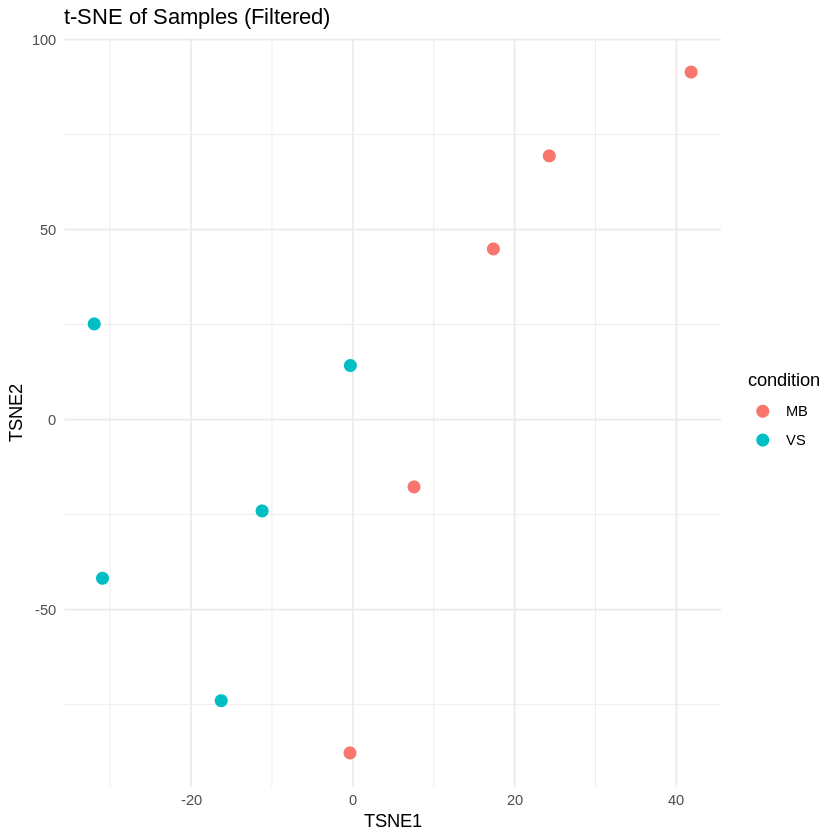

In [12]:
# tSNE

# Set seed for reproducibility - necessary for tSNE
set.seed(123)

# Convert vsd to a matrix
vsd_matrix <- assay(vsd)
# Transpose 'vsd' so that rows are samples
vsd_transposed <- t(vsd_matrix)

# Running t-SNE on the transposed data
tsneData <- Rtsne(vsd_transposed, dims = 2, perplexity = 3, verbose = TRUE, max_iter = 1000)

# Extracting the t-SNE coordinates
tsne_df <- data.frame(tsneData$Y)
colnames(tsne_df) <- c("TSNE1", "TSNE2")

# Adding condition data to the t-SNE DataFrame
tsne_df$condition <- factor(c("MB", "MB", "MB", "MB", "MB", "VS", "VS", "VS", "VS", "VS"))  # Match condition based on row names

# Plotting the t-SNE data
ggplot(tsne_df, aes(TSNE1, TSNE2, color = condition)) +
  geom_point(size = 3) +
  labs(title = "t-SNE of Samples (Filtered)",
       x = "TSNE1",
       y = "TSNE2") +
  theme_minimal()

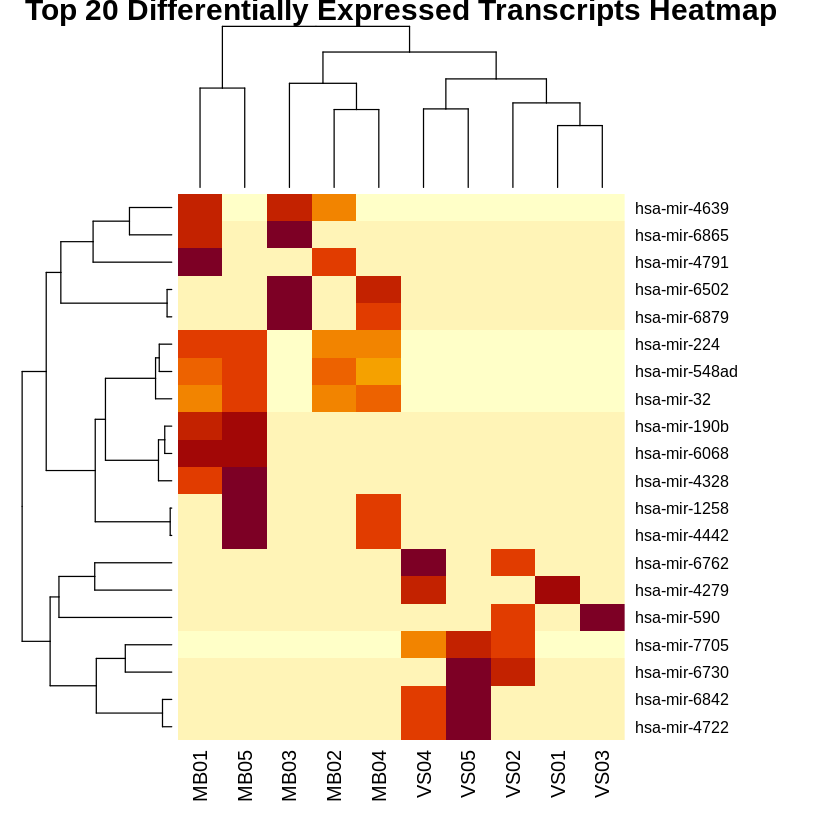

In [13]:
# Heatmap for top differentially expressed transcripts
valid_genes <- order(res$padj, na.last = NA)
num_genes <- min(20, length(sig_res$padj))  # Use at most 20 genes or all sig genes if less

if (num_genes > 0) {
  top_genes <- head(valid_genes, num_genes)
  normalized_counts <- assay(vsd)[top_genes, ]
  heatmap_data <- normalized_counts - rowMeans(normalized_counts)
  heatmap(heatmap_data,
          Colv = TRUE,  # Cluster samples
          Rowv = TRUE,  # Cluster transcripts - looks better without it?
          scale = "row",
          main = paste("Top", num_genes, "Differentially Expressed Transcripts Heatmap"),
          margins = c(5, 10))
} else {
  cat("No genes available for heatmap.\n")
}

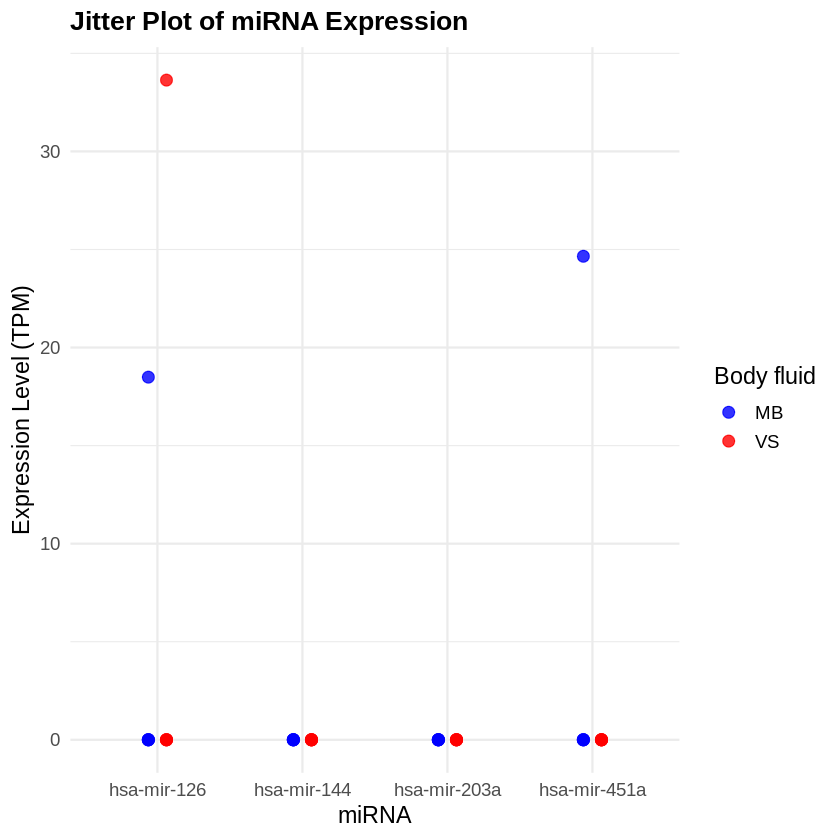

In [14]:
# plot original miRNAs interested in

data <- read.csv("normalized_all_counts.csv", check.names = FALSE)
colnames(data)[1] <- "miRNA"

# Filter the data for the four specific miRNAs
filtered_data <- data[data$miRNA %in% c("hsa-mir-126", "hsa-mir-451a", "hsa-mir-144", "hsa-mir-203a"),]

# Reshape data
long_data <- pivot_longer(filtered_data, cols = -miRNA, names_to = "Sample", values_to = "Expression")

# Create a new column for the series type (MB or VS)
long_data$Series <- ifelse(grepl("MB", long_data$Sample), "MB", "VS")

# Create the jitter plot with enhanced aesthetics
ggplot(long_data, aes(x = miRNA, y = Expression, color = Series)) +
  geom_point(position = position_dodge(width = 0.25), size = 3, alpha = 0.8) +  # Adjust point size and transparency
  theme_minimal(base_size = 14) +  # Increase base font size for better readability
  theme(
    plot.title = element_text(face = "bold", size = 16),
    axis.title = element_text(size = 14),
    legend.title = element_text(size = 14),
    legend.position = "right"
  ) +
  labs(
    title = "Jitter Plot of miRNA Expression",
    x = "miRNA",
    y = "Expression Level (TPM)",
    color = "Series"  # Add legend title
  ) +
  scale_color_manual(values = c("MB" = "blue", "VS" = "red")) +
  guides(color = guide_legend(title = "Body fluid"))  # Explicit guide for legend to adjust title
